# Locality Preserving Projections

[Locality preserving projection (LPP)](http://people.cs.uchicago.edu/~xiaofei/LPP.html) was introduced by Xiaofei He and Partha Niyogi at NIPS 2003. They provide a MATLAB implementation, but we'll be implementing it using scikit-learn, which provides some nice features that will do much of the work for us.

LPP is a manifold learning technique for dimensionality reduction, useful when you have high-dimensional input that you suspect can be described well in only a few dimensions and want to work with it in a space of much lower dimensionality. The classic example, and the one implemented in the NIPS paper, is projecting images of faces to 2D space for visualization.

The algorithm is based on spectral graph theory, and the main idea is to construct a graph in which like samples are connected with large weights, then project the samples to the low-dimensional space while maintaining the neighborhood structure. It results in a linear transformation matrix, so it allows for out-of-sample projection. There is also a kernelized version, which allows for nonlinear transformations.

## Preliminaries

First, let's define some notation to make the rest of the tutorial easier to follow. Each sample in the dataset will be denoted by $\mathbf{x}_i$. It is common in derivations to consider data points to be represented by column vectors, but it is more natural in programming the algorithms to denote single data points as arrays, which end up as rows in a matrix of we put many of them together. The focus here will be more on programming than the underlying math, so we'll assume our dataset consists of $m$ points in $n$-dimensional space, forming a $m \times n$ matrix $X$.

The goal of the algorithm is to project the points in $X$ to a corresponding set of points $\mathbf{y}_1,\,\mathbf{y}_2,\,\dots,\,\mathbf{y}_m$, where $\mathbf{y}_i$ exists in $l$-dimensional space and $l \ll n$. That is, we want to project our data set to a much lower dimensional space. For example, we might have $20\times20$-pixel images ($n = 400$) that we want to visualize in a 2D plot ($l = 2$). This projection will be performed linearly, so our real goal is to find a



## Step 1: Construct the Adjacency Graph

An adjacency graph simply describes which input samples are connected. Inputs that are similar should be connected (i.e. they are neighbors), and inputs that are dissimilar should not be connected. A simple way to represent the adjacency graph is an $m \times m$ matrix, where $m$ is the number of samples you have. If input $\mathbf{x}_i$ is connected to $\mathbf{x}_j$, the entry of the matrix at row $i$ and column $j$ is $1$, otherwise it is $0$. The matrix is then symmetric (if $\mathbf{x}_i$ is connected to $\mathbf{x}_j$, then $\mathbf{x}_j$ is connected to $\mathbf{x}_i$) and it is likely sparse (depending on how neighbors are determined).

He and Niyogi describe two methods of determining which samples are close to one another:

* $\epsilon$-neighborhoods: nodes $i$ and $j$ are connected if $||\mathbf{x}_i - \mathbf{x}_j||^2_2 < \epsilon$
* $k$ nearest neighbor: nodes $i$ and $j$ are connected if $i$ is one of $k$ nearest neighbors of $j$ or vice versa (neighbors determined by Euclidean distance)

The authors also note that adjacency can be determined using other (less principled) methods and that LPP will attempt to preserve those neighborhoods.

scikit-learn has a subpackage (`neighbors`) for creating graphs and such. This makes it really easy to construct either of these adjacency graphs. By default, we'll cheat and have the adjacency matrices represent the connections by their Euclidean distance, unless `mode='connectivity'` is passed in. This will make step 2 easier in some cases.

In [1]:
from sklearn import neighbors

def radius_adj(X, radius, mode='distance'):
    A = neighbors.radius_neighbors_graph(X, radius, mode=mode)
    return A

def kneighbors_adj(X, n_neighbors, mode='distance'):
    A = neighbors.kneighbors_graph(X, n_neighbors, mode=mode)
    return A

## Step 2: Choose Weights

Since the adjacency graph specifies only which nodes are connected, we use a separate matrix to represent how strongly the connected nodes are connected. Like the adjacency graph, the weights are represented by an $m \times m$ matrix $W$. Again, the authors offer two options for determining the weights:

* Heat kernel: $W_{ij} = \exp \left( \frac{||\mathbf{x}_i - \mathbf{x}_j ||^2_2}{t} \right)$ if nodes $i$ and $j$ are connected and zero otherwise
* Simple: $W_{ij} = 1$ if nodes $i$ and $j$ are connected and zero otherwise

For the heat kernel, we'll rely on the ability of the graph constructors of scikit-learn to return the distances between neighbors. This makes the weight calculations simpler.

For the simple weight option, pass `mode='connectivity'` to the adjacency matrix construction function and the resulting weight matrix will be the same as the adjacency matrix.

In [2]:
import numpy as np

def heat_kernel_weights(dists, param):
    W = -dists**2/param
    np.exp(W.data, W.data)
    return W

## Step 3: Compute the Eigenmapping

The final step involves solving the generalized eigen-problem:

$$
X^T L X \mathbf{a} = \lambda X^T D X \mathbf{a}
$$

Where $D$ is the diagonal matrix whose elements are the column-wise sums of $W$, and $L = D - W$ is the graph Laplacian. The nice thing here is that the products of matrices on both sides produce symmetric matrices, so we can use algorithms that are tuned for solving the eigenvalue problem for symmetric matrices.

The matrix of eigenvectors (i.e. the matrix whose columns are the eigenvectors arranged in order by increasing eigenvalue) then give us the transformation matrix to take inputs and transform them to the lower dimensional space. That is, we use the first $l$ eigenvectors (first meaning those with the smallest eigenvalues) to perform an embedding to $l$-dimensional space.

In [3]:
from scipy.linalg import eigh

def compute_mapping(W, l):
    D = np.diagflat(W.sum(axis=0))
    L = D - W
    eigvals, eigvecs = eigh(X.T.dot(L).dot(X),
                            X.T.dot(D).dot(X),
                            eigvals=(0, l-1))
    return eigvecs

## Putting it Together

We'll put things together to make a simple interface to LPP.

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin

class LocalityPreservingProjection(BaseEstimator, TransformerMixin):
    
    def __init__(self, n_components=2, adjacency='kneighbors',
                 adjacency_param=3, weights='heatkernel',
                 kernel_param=0.1):
        self.n_components = n_components
        self.adjacency = adjacency
        self.adjacency_param = adjacency_param
        self.weights = weights
        self.kernel_param = kernel_param
        
    def fit(self, X, y=None):
        if self.adjacency == 'kneighbors':
            adj_func = kneighbors_adj
        else:
            adj_func = radius_adj
            
        if self.weights == 'heatkernel':
            mode = 'distance'
        else:
            mode = 'connectivity'
            
        W = adj_func(X, self.adjacency_param, mode=mode)
        
        if self.weights == 'heatkernel':
            W = heat_kernel_weights(W, self.kernel_param)
        
        self.components_ = compute_mapping(W, self.n_components)
        
        return self
            
    def transform(self, X):
        return X.dot(self.components_)

## Trying it Out

(3, 2)


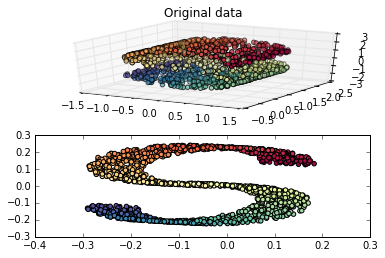

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
Axes3D

from sklearn import datasets

np.random.seed(12345)

X, color = datasets.samples_generator.make_s_curve(n_samples=1500)

lpp = LocalityPreservingProjection(n_components=2,
                                   adjacency='radius',
                                   adjacency_param=0.01)
lpp.fit(X)
print(lpp.components_.shape)
X_r = lpp.transform(X)

fig = plt.figure()
ax = fig.add_subplot(211, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.set_title("Original data")

ax = fig.add_subplot(212)
ax.scatter(X_r[:, 0], X_r[:, 1], c=color, cmap=plt.cm.Spectral)

plt.show()

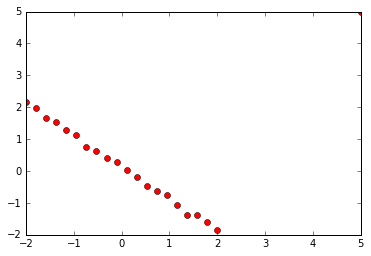

In [6]:
X = np.zeros((21, 2))
x0 = np.linspace(-2, 2, 20)
x1 = -x0 + 0.2*np.random.rand(20)
X[:-1, 0] = x0
X[:-1, 1] = x1
X[-1] = [5]

plt.plot(X[:, 0], X[:, 1], 'ro')

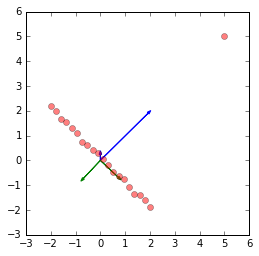

In [7]:
from sklearn import decomposition

pca = decomposition.PCA().fit(X)

lpp = LocalityPreservingProjection(n_components=2,
                                   adjacency='kneighbors',
                                   adjacency_param=4).fit(X)

vlpp = lpp.components_
vpca = pca.components_

plt.plot(X[:, 0], X[:, 1], 'ro', alpha=0.5)

plt.arrow(0, 0, vlpp[0, 0], vlpp[1, 0], head_width=0.1, fc='b', ec='b')
plt.arrow(0, 0, vlpp[0, 1], vlpp[1, 1], head_width=0.1, fc='b', ec='b')
plt.arrow(0, 0, vpca[0, 0], vpca[1, 0], head_width=0.1, fc='g', ec='g')
plt.arrow(0, 0, vpca[0, 1], vpca[1, 1], head_width=0.1, fc='g', ec='g')
plt.xlim(-3, 6)
plt.ylim(-3, 6)
plt.gca().set_aspect(1)